# Multiclass Classification of White Wine Quality with Over-sampling and k-NN

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
<pre>
Dua, D. and Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: University of California, School of Information and Computer Science.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

white_wine = pd.read_csv('../../ch_10/data/winequality-white.csv', sep=';')

## EDA

In [2]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


<AxesSubplot:title={'center':'White Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

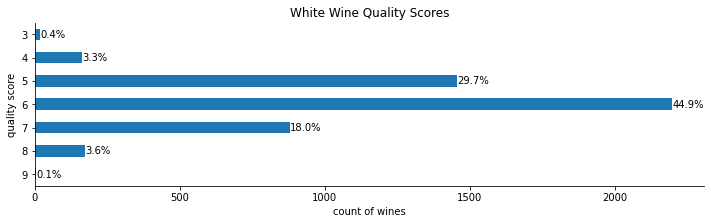

In [5]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(white_wine, 'white')

## White wine quality multiclass classification

### Train test split

In [6]:
from sklearn.model_selection import train_test_split

y = white_wine.quality
X = white_wine.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0, stratify=y
)

### Over-sampling

In [7]:
from imblearn.over_sampling import RandomOverSampler

X_train_oversampled, y_train_oversampled = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
pd.Series(y_train_oversampled).value_counts()

8    1868
9    1868
3    1868
4    1868
5    1868
6    1868
7    1868
Name: quality, dtype: int64

### Building a model

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])

search_space = {
    'knn__n_neighbors': np.arange(1, 10)
}

grid = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(X_train_oversampled, y_train_oversampled)

Check the best hyperparameters:

In [9]:
grid.best_params_

{'knn__n_neighbors': 1}

### Evaluating the model
Get the predictions:

In [10]:
preds = grid.predict(X_test)

Review the classification report:

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.45      0.42      0.43        24
           5       0.68      0.68      0.68       219
           6       0.66      0.71      0.68       330
           7       0.53      0.45      0.49       132
           8       0.39      0.46      0.42        26
           9       0.00      0.00      0.00         1

    accuracy                           0.63       735
   macro avg       0.39      0.39      0.39       735
weighted avg       0.62      0.63      0.63       735



/home/stefaniemolin/book_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inpsect the confusion matrix:

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

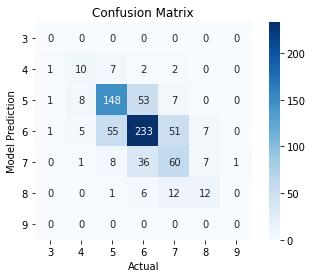

In [12]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_test, preds, np.sort(y.unique()))

Make precision-recall curves:

array([<AxesSubplot:title={'center':'Precision-recall curve: class 3'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 4'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 5'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 6'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 7'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 8'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 9'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

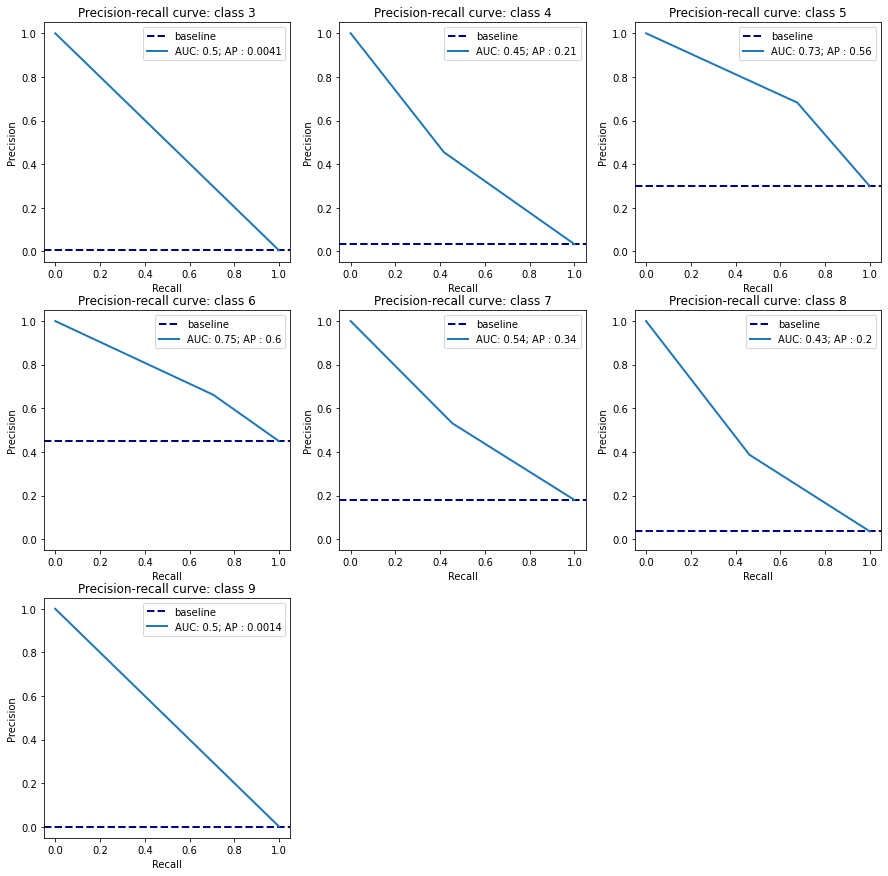

In [13]:
from ml_utils.classification import plot_multiclass_pr_curve
plot_multiclass_pr_curve(y_test, grid.predict_proba(X_test))

<hr>
<div>
    <a href="./exercise_2.ipynb">
        <button>&#8592; Previous Solution</button>
    </a>
    <a href="./exercise_4.ipynb">
        <button style="float: right;">Next Solution &#8594;</button>
    </a>
</div>
<hr>